In [1]:
#  Required imports

import configparser, pickle, os, sys
import numpy as np
from matplotlib import pyplot as plt

In [2]:
#  Program constants

input_data_fname    = 'event_parser_output.dat'
output_pickle_fname = 'event_parser_output.pickle'
plots_save_file     = 'event_parser_output.pdf'

In [3]:
#  Brief: function turns a string into a vector, assuming string formatted as "['A', 'B', 'C']" or "[A, B, C]"
#  - simple non-generalisable function, only works assuming the correct formatting
#
def str_to_vec (string, delim=",") :
    string = string.replace("[","")
    string = string.replace("]","")
    string = string.replace(" ","")
    string = string.replace("'","")
    return [x for x in string.split(delim) if len(x) > 0]

In [4]:
#  Class DataTable
#    -  store event-level observable values and weights, observable names and their types
#    -  can be saved to pickle file
#    -  can be loaded from pickle file, or from a text file produced by Rivet
#
class DataTable :
    #
    #  Brief:  Constructor
    #     - If fname provided, we will load it if we recognise the extension as a text- or pickle-file
    #
    def __init__ (self, fname=None) :
        self.keys    = None
        self.types   = None
        self.events  = None
        if type(fname) == type(None) : return
        fname_extension = fname.split(".")[-1]
        if   fname_extension in ["dat", "text", "txt"] : 
            self.load_from_text_file (fname)
        elif fname_extension in ["pickle", "p"] : 
            self.load_from_pickle_file (fname)
        else :
            raise RuntimeWarning(f"File type extension not recognised from filename {fname}. Returning without loading.")
    #
    #  Brief:  Load values from a pickle file
    #    - Pickle file created by this class (see self.save_to_pickle_file())
    #
    def load_from_pickle_file (self, fname) :
        if not os.path.isfile : raise RuntimeError(f"File {fname} does not exist")
        #
        #   Load pickle file, and make sure the expected entries are present
        #
        f = pickle.load(open(fname, "rb"))
        if type(f) != dict : raise TypeError(f"Expected contents of pickle file {fname} to be type {dict} but {type(f)} found")
        for required_entry in ["Keys", "Types", "Events", "Xsec_per_event"] :
            if required_entry in f : continue
            raise RuntimeError(f"Entry {required_entry} not found in pickle file {fname}")
        #
        #   Save values
        #
        self.keys           = keys
        self.types          = types
        self.events         = events
        self.xsec_per_event = xsec_per_event
    #
    #  Brief:  Load values from a text file
    #    - Text file is produce by a Rivet routine, and must be formatted correctly
    #
    def load_from_text_file (self, fname) :
        if not os.path.isfile : raise RuntimeError(f"File {fname} does not exist")
        #
        #   Load config file, and make sure the expected entries are present
        #
        config = configparser.ConfigParser()
        config.read(fname)
        if "DATA" not in config.sections() :
            raise RuntimeError(f"Header DATA not found in file {fname}")
        data = config["DATA"]
        for required_entry in ["Keys", "Events", "Xsec_per_event"] :
            if required_entry in data : continue
            raise RuntimeError(f"Entry [DATA]::{required_entry} not found in file {fname}")
        #
        #   Load the keys from the config file
        #
        self.keys, self.types = [], []
        for entry in str_to_vec(data["Keys"]) :
            split_entry = entry.split("::")
            if len(split_entry) == 2 :
                str_type = split_entry[0]
                if   str_type.lower() == "float" : self.types.append(float)
                elif str_type.lower() == "int"   : self.types.append(int)
                else : raise RuntimeError(f"Key {entry} type not recognised")
                self.keys.append(split_entry[1])
            elif len(split_entry) == 1 :
                self.types.append(float)
                self.keys.append(split_entry[0])
            else : raise RuntimeError(f"Key {entry} format not recognised")
        num_keys = len(self.keys)
        #
        #   Load the event data from the config file
        #
        events = []
        for line in data["Events"].split("\n") :
            vec_line = str_to_vec(line)
            if len(vec_line) != num_keys :
                raise RimetimeError(f"Event '{line}' has {len(vec_line)} entries where {num_keys} expected")
            row = []
            for entry, typ in zip(vec_line, self.types) :
                row.append(typ(entry))
            events.append(row)
        self.events         = np.array(events)
        self.xsec_per_event = float(data["Xsec_per_event"])
    #
    #  Brief:  Plot contents
    #
    def plot_contents (self, show=True, save=None) :
        keys, events = self.keys, self.events
        num_keys = len(keys)
        num_events = events.shape[0]
        weight_index = keys.index("weight") if "weight" in keys else -1
        if weight_index < 0 : weights = np.full(fill_value=1./num_events, shape=(num_events,))
        else                : weights = events[:, weight_index]
        sum_weights  = np.sum(weights)
        print(f"Num events is {num_events}")
        print(f"Sum of weights is {sum_weights}")
        print(f"Total cross section is {sum_weights*self.xsec_per_event} pb")
        weights = weights*self.xsec_per_event
        num_columns = 4
        num_rows    = np.ceil(num_keys/4)
        fig = plt.figure(figsize=(3*num_columns, 3*num_rows))
        for key_idx in range(num_keys) :
            ax  = fig.add_subplot(num_rows, num_columns, 1+key_idx)
            data_x = np.array([x for x in events[:, key_idx] if x != -99])
            if (weight_index < 0) or (key_idx == weight_index) :
                data_w = np.ones(shape=data_x.shape)
            else : 
                data_w = np.array([w for x, w in zip(events[:, key_idx], weights) if x != -99])
            ax.hist(data_x, weights=data_w)
            ax.set_title(f"{keys[key_idx]}", weight="bold", fontsize=15)
            #ax.set_yscale("log")
        plt.subplots_adjust(left=0.05, right=0.95, bottom=0.05, top=0.95, wspace=0.35, hspace=0.35)
        if type(save) != type(None) :
            plt.savefig(save, bbox_inches="tight")
        if show :
            plt.show()
    #
    #  Brief:  Print the loaded keys and data summary
    #
    def print_summary (self) :
        key_width, type_width = max(4, max([len(s) for s in self.keys])), max(4, max([len(str(t)) for t in self.types]))
        header = f"    | Column | {'Name'.ljust(key_width)} | {'Type'.ljust(type_width)} |"
        line_width = len(header) - 4
        num_keys = len(self.keys)
        print(f"* Registered the following keys:")
        print("    +-" + "-"*(line_width-4) + "-+")
        print(f"{header}")
        print("    +-" + "-"*(line_width-4) + "-+")
        for col_idx, (key, typ) in enumerate(zip(self.keys, self.types)) :
            print(f"    | {str(col_idx).ljust(6)} | {key.ljust(key_width)} | {str(typ).ljust(type_width)} |")
        print("    +-" + "-"*(line_width-4) + "-+")
        print("\n" + f"* Number of events loaded: {self.events.shape[0]}")
        print("\n" + f"* Cross-section per event: {self.xsec_per_event}")
    #
    #  Brief:  save the table contents to a pickle file (in a format which can be loaded elsewhere)
    #
    def save_to_pickle_file (self, fname) :
        if type(self.keys          ) == type(None) : raise RuntimeError("Cannot save model whilst self.keys is None")
        if type(self.types         ) == type(None) : raise RuntimeError("Cannot save model whilst self.types is None")
        if type(self.events        ) == type(None) : raise RuntimeError("Cannot save model whilst self.events is None")
        if type(self.xsec_per_event) == type(None) : raise RuntimeError("Cannot save model whilst self.xsec_per_event is None")
        to_save = {}
        to_save ["Keys"          ] = self.keys
        to_save ["Types"         ] = self.types
        to_save ["Events"        ] = self.events
        to_save ["Xsec_per_event"] = self.xsec_per_event
        pickle.dump(to_save, open(fname, "wb"))
        

Loading input file event_parser_output.dat... done.

Printing contents...
* Registered the following keys:
    +---------------------------------------+
    | Column | Name       | Type            |
    +---------------------------------------+
    | 0      | weight     | <class 'float'> |
    | 1      | m_ll       | <class 'float'> |
    | 2      | pT_ll      | <class 'float'> |
    | 3      | theta_ll   | <class 'float'> |
    | 4      | rap_ll     | <class 'float'> |
    | 5      | m_jj       | <class 'float'> |
    | 6      | pT_jj      | <class 'float'> |
    | 7      | theta_jj   | <class 'float'> |
    | 8      | rap_jj     | <class 'float'> |
    | 9      | pT_j1      | <class 'float'> |
    | 10     | pT_j2      | <class 'float'> |
    | 11     | Dy_j_j     | <class 'float'> |
    | 12     | Dphi_j_j   | <class 'float'> |
    | 13     | N_jets     | <class 'int'>   |
    | 14     | N_gap_jets | <class 'int'>   |
    +---------------------------------------+

* Number of events

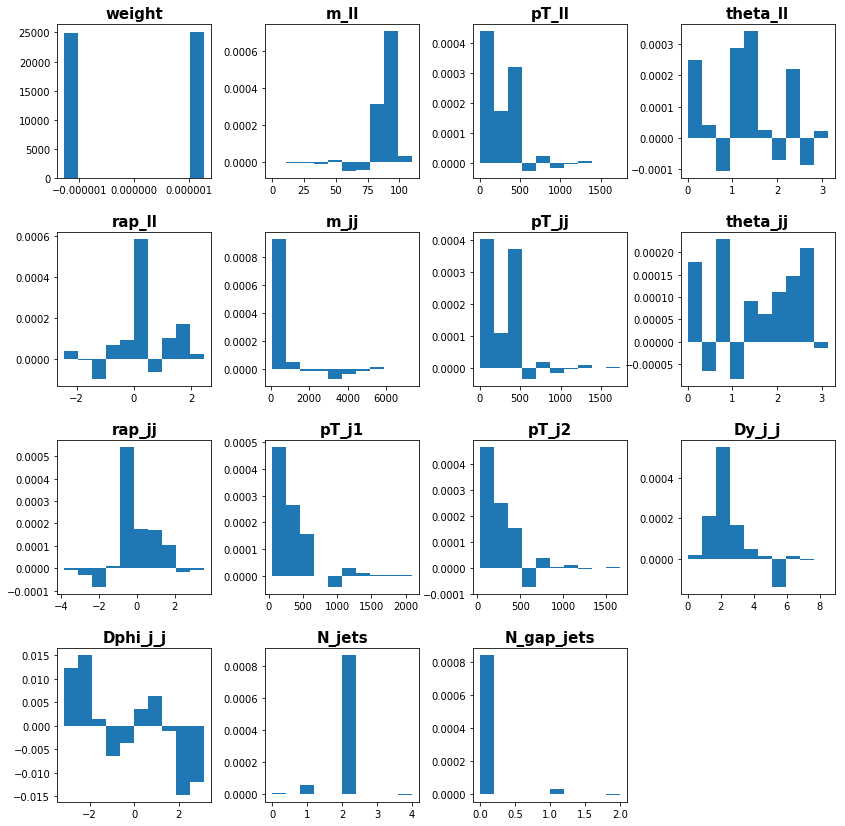

In [5]:
sys.stdout.write(f"Loading input file {input_data_fname}...")
data = DataTable(input_data_fname)
sys.stdout.write(" done.\n\n")
sys.stdout.flush()

print(f"Printing contents...")
data.print_summary()

sys.stdout.write(f"\nSaving data to pickle file {output_pickle_fname}...")
data.save_to_pickle_file(output_pickle_fname)
sys.stdout.write(" done.\n")
sys.stdout.flush()

print(f"\nPlotting contents...")
data.plot_contents(save=plots_save_file)